## Importing libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pylab import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (8523, 12)
Test: (5681, 11)


In [3]:
train_df['source']='train'
test_df['source']='test'
data_df=pd.concat([train_df,test_df],ignore_index=True)
print("Data:",data_df.shape)
data_df.head()

Data: (14204, 13)


,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


## EDA

### Checking missing values in dataset

In [4]:
data_df.apply(lambda x:sum(x.isnull()),axis=0)

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

### Checking unique values in columns

In [5]:
data_df.apply(lambda x: len(x.unique()),axis=0)

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

### Checking columns stats

In [6]:
#Continous variables
data_df.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [7]:
# Categorical Variable
print(data_df.dtypes)
categorical_columns=[x for x in data_df.dtypes.index if data_df.dtypes[x]=="object"]
print("Categorical:",categorical_columns)

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
dtype: object
Categorical: ['Item_Fat_Content', 'Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'source']


In [8]:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier']]
for col in categorical_columns:
    print(data_df[col].value_counts(),'\n')

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64 

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64 

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64 

Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64 

Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64 

train    8523
test     5681
Name: source, dtype: int64 



## Data Cleaning

### Imputation in Item_Weight

In [9]:
item_avg_weight=data_df.pivot_table(values='Item_Weight',index='Item_Identifier')

In [10]:
missing_values=data_df['Item_Weight'].isnull()
print("Missing:",sum(missing_values))
data_df.loc[missing_values,'Item_Weight']= data_df.loc[missing_values,'Item_Identifier'].apply(lambda x : item_avg_weight.ix[x])
print("Final Missing:",sum(data_df['Item_Weight'].isnull()))

Missing: 2439
Final Missing: 0


### Imputation in Outlet_size

In [11]:
outlet_size_mode=data_df.pivot_table(values='Outlet_Size',index='Outlet_Type',aggfunc=(lambda x: x.mode().iat[0]))
print(outlet_size_mode)

                  Outlet_Size
Outlet_Type                  
Grocery Store           Small
Supermarket Type1       Small
Supermarket Type2      Medium
Supermarket Type3      Medium


In [12]:
missing_values=data_df['Outlet_Size'].isnull()
print("Missing:",sum(missing_values))
data_df.loc[missing_values,'Outlet_Size']=data_df.loc[missing_values,'Outlet_Type'].apply(lambda x: outlet_size_mode.ix[x])
print("Final Missing:",sum(data_df['Outlet_Size'].isnull()))

Missing: 4016
Final Missing: 0


## Feature Engineering

### Item_Visibility

In [13]:
visiblity_avg=data_df.pivot_table(values="Item_Visibility",index="Item_Identifier")
visiblity_avg.head()

,Item_Visibility
Item_Identifier,
DRA12,0.034938
DRA24,0.045646
DRA59,0.133384
DRB01,0.079736
DRB13,0.006799


In [14]:
missing_values=data_df['Item_Visibility']==0
print("Missing values:",sum(missing_values))
data_df.loc[missing_values,'Item_Visibility']=data_df.loc[missing_values,'Item_Identifier'].apply(lambda x: visiblity_avg.ix[x])
print("Final Missing:",sum(data_df['Item_Visibility']==0))

Missing values: 879
Final Missing: 0


### Adding new columns/features

In [15]:
#Determine another variable with means ratio
data_df['Item_Visibility_MeanRatio'] = data_df.apply(lambda x: x['Item_Visibility']/visiblity_avg.ix[x['Item_Identifier']], axis=1)
print(data_df['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


### Modification of values

In [16]:
#Get the first two characters of ID:
data_df['Item_Type_Combined'] = data_df['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data_df['Item_Type_Combined'] = data_df['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data_df['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [17]:
#Years:
data_df['Outlet_Years'] = 2013 - data_df['Outlet_Establishment_Year']
data_df['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [18]:
print(data_df['Item_Fat_Content'].value_counts())
data_df['Item_Fat_Content']=data_df['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                                'reg':'Regular',
                                                                'low fat':'Low Fat'})
print(data_df['Item_Fat_Content'].value_counts())

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [19]:
data_df.loc[data_df['Item_Type_Combined']=='Non-Consumable','Item_Fat_Content']="Non-Edible"
print(data_df['Item_Fat_Content'].value_counts())

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64


### Numerical & One hot coding (Changing categorical vairable to columns of 0/1)

In [20]:
#New variable for outlet
le=LabelEncoder()
data_df['Outlet']=le.fit_transform(data_df['Outlet_Identifier'])

In [21]:
var_mod=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
for i in var_mod:
    data_df[i] = le.fit_transform(data_df[i])
data_df.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Visibility_MeanRatio,Item_Type_Combined,Outlet_Years,Outlet
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,0,1,1,train,0.931078,1,14,9
1,2,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,2,1,2,train,0.933420,0,4,3
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,0,1,1,train,0.960069,1,14,9
3,2,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,1998,OUT010,2,2,0,train,1.000000,1,15,0
4,1,NCD19,53.8614,994.7052,Household,0.009780,8.93,1987,OUT013,2,0,1,train,1.000000,2,26,1


In [22]:
data_df=pd.get_dummies(data_df,columns=var_mod)
data_df.head()

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,source,Item_Visibility_MeanRatio,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,train,0.931078,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,train,0.933420,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,train,0.960069,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,Fruits and Vegetables,0.017834,19.20,1998,OUT010,train,1.000000,...,1,0,0,0,0,0,0,0,0,0
4,NCD19,53.8614,994.7052,Household,0.009780,8.93,1987,OUT013,train,1.000000,...,0,1,0,0,0,0,0,0,0,0


## Exporting Data

In [23]:
data_df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)
train_df=data_df.loc[data_df['source']=='train']
test_df=data_df.loc[data_df['source']=='test']

In [24]:
test_df.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train_df.drop(['source'],axis=1,inplace=True)

train_df.to_csv("train_modified.csv",index=False)
test_df.to_csv("test_modified.csv",index=False)

## Model Building

### Baseline prediction

In [25]:
mean_sales=train_df['Item_Outlet_Sales'].mean()
base1=test_df[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales']=mean_sales
base1.to_csv("algo0.csv",index=False)

### Defining variables & function for models

In [26]:
target = 'Item_Outlet_Sales'
id_col = ['Item_Identifier','Outlet_Identifier']

In [27]:
def model_fit(algo,train_data,test_data,predictors,target,id_col,filename):
    
    algo.fit(train_data[predictors],train_data[target])
    
    train_predictions=algo.predict(train_data[predictors])
    
    cv_score=cross_validation.cross_val_score(algo,
                                              train_data[predictors],
                                              train_data[target],
                                              cv=20,
                                              scoring='mean_squared_error')
    cv_score=np.sqrt(np.abs(cv_score))
    
    print("RMSE: ",np.sqrt(metrics.mean_squared_error(train_data[target].values,train_predictions)))
    print("CV score: Mean-", np.mean(cv_score),
          " Std-", np.std(cv_score),
          " Min-", np.min(cv_score), 
          " Max-",np.max(cv_score))
    
    test_data[target]=algo.predict(test_data[predictors])
    
    id_col.append(target)
    submission=pd.DataFrame({x:test_data[x] for x in id_col})
    submission.to_csv(filename,index=False)

### Linear Regression

RMSE:  1127.38038588
CV score: Mean- 1128.94705999  Std- 43.1607037891  Min- 1074.71697493  Max- 1210.34680171


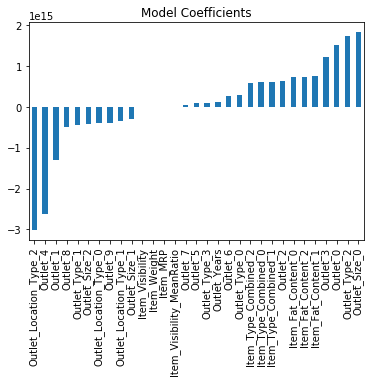

In [60]:
predictors=[x for x in train_df.columns if x not in [target]+id_col]
alg1=LinearRegression(normalize=True)
model_fit(alg1,train_df,test_df,predictors,target,id_col,'linear.csv')
coef1=pd.Series(alg1.coef_,predictors).sort_values()
coef1.plot(kind='bar',title='Model Coefficients')

### Decision Tree

RMSE:  1057.69349417
CV score: Mean- 1091.4994114  Std- 45.416892289  Min- 1002.7950801  Max- 1186.41085677


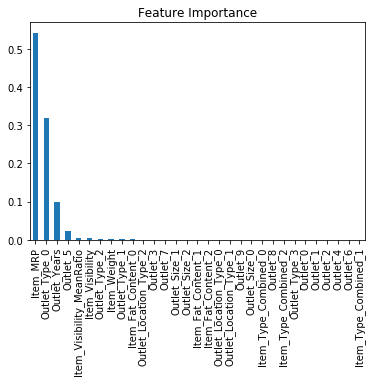

In [61]:
predictors=[x for x in train_df.columns if x not in [target]+id_col]
alg2=DecisionTreeRegressor(max_depth=15,min_samples_leaf=100)
model_fit(alg2,train_df,test_df,predictors,target,id_col,'decision_tree.csv')
coef2=pd.Series(alg2.feature_importances_,predictors).sort_values(ascending=False)
coef2.plot(kind='bar',title='Feature Importance')

RMSE:  1071.2364214
CV score: Mean- 1096.10654021  Std- 43.3021190003  Min- 1027.34401644  Max- 1171.50223057


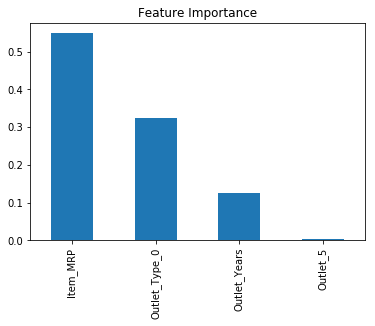

In [62]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg3=DecisionTreeRegressor(max_depth=8,min_samples_leaf=150)
model_fit(alg3,train_df,test_df,predictors,target,id_col,'decision_tree_v2.csv')
coef3=pd.Series(alg3.feature_importances_,predictors).sort_values(ascending=False)
coef3.plot(kind='bar',title='Feature Importance')

### Random Forest

RMSE:  1073.22054781
CV score: Mean- 1083.62337252  Std- 43.9695847961  Min- 1019.19199801  Max- 1162.15555555


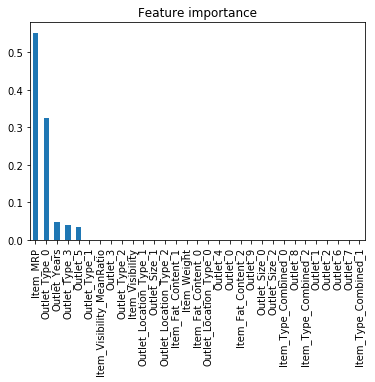

In [63]:
predictors=[x for x in train_df.columns if x not in [target]+id_col]
alg4=RandomForestRegressor(n_estimators=200,max_depth=5,min_samples_leaf=100,n_jobs=4)
model_fit(alg4,train_df,test_df,predictors,target,id_col,'random_forest.csv')
coef4=pd.Series(alg4.feature_importances_,predictors).sort_values(ascending=False)
coef4.plot(kind='bar',title='Feature importance')